In [1]:
import geopandas as gpd
import pandas as pd
import ee
import numpy as np
from scipy.stats import linregress, gaussian_kde
from src.data import mtbs
from src.data import raster
from src.data import pd_utils
from src.data import gedi_pipeline
from src.visualization.dists import plot_pdf
from src.visualization.gedi_viz import geo_plot
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from src.data import k_nn

sns.set_theme()

import importlib
importlib.reload(raster)
importlib.reload(gedi_pipeline)
importlib.reload(k_nn)

2023-05-23 10:39:23,506 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.k_nn' from '/home/jk871/fire-regen/src/data/k_nn.py'>

In [2]:
gedi_gpd = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
print(f'Total number of GEDI shots available for the region: {gedi_gpd.shape[0]}')

Total number of GEDI shots available for the region: 15628961


In [3]:
gedi_gpd = gedi_pipeline.process_shots(gedi_gpd)

In [4]:
gedi_burned, gedi_unburned = gedi_pipeline.filter_shots(gedi_gpd)

2023-05-23 12:29:51,351 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:36]
2023-05-23 12:29:52,051 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:41]
2023-05-23 12:29:55,140 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:47]


In [5]:
gedi_burned = gedi_pipeline.filter_shots_for_regrowth_analysis(gedi_burned)

2023-05-23 12:30:58,157 DEBUG: Number of shots that happened after fires:                    1928239 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:64]
2023-05-23 12:30:58,633 DEBUG: Number of shots that burned exactly once:                    1671762 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:69]
2023-05-23 12:30:59,232 DEBUG: Number of shots that burned in 2-4 categories:                    1423368 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:74]
2023-05-23 12:30:59,495 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1029725 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:78]


In [6]:
gedi_burned_trees = gedi_pipeline.filter_for_trees(gedi_burned)
gedi_unburned_trees = gedi_pipeline.filter_for_trees(gedi_unburned)
print(f'GEDI shots that burned trees: {gedi_burned_trees.shape[0]}')
print(f'GEDI tree shots that didn\'t burn: {gedi_unburned_trees.shape[0]}')

GEDI shots that burned trees: 349225
GEDI tree shots that didn't burn: 4181114


In [7]:
gedi_trees = pd.concat([gedi_burned_trees, gedi_unburned_trees])
print(f'Total GEDI shots on trees: {gedi_trees.shape[0]}')

Total GEDI shots on trees: 4530339


In [10]:
gedi_trees.columns

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'fhd_normal', 'pai', 'pai_z', 'pavd_z', 'rh100', 'cover', 'cover_z',
       'beam_type', 'sensitivity', 'gridded_pft_class', 'geometry',
       'burn_severity_2x2', 'burn_severity_mean', 'burn_severity_std',
       'burn_severity_median', 'burn_year_2x2', 'burn_year_mean',
       'burn_year_std', 'burn_year_median', 'burn_counts_2x2',
       'burn_counts_mean', 'burn_counts_std', 'burn_counts_median',
       'land_cover_2x2', 'land_cover_mean', 'land_cover_std',
       'land_cover_median', 'gedi_year', 'gedi_month', 'time_since_burn'],
      dtype='object')

In [12]:
gedi_trees = gedi_trees.drop(columns=['burn_severity_2x2',
    'burn_severity_mean', 'burn_severity_std', 'burn_year_2x2', 'burn_year_mean', 
    'burn_year_std', 'burn_counts_2x2', 'burn_counts_mean', 'burn_counts_std', 'land_cover_2x2', 'land_cover_mean', 'land_cover_std', 
    'land_cover_median'])

In [13]:
gedi_trees.to_csv('/maps/fire-regen/data/gedi_l2b_sierras_burn_lc_matched_trees_trimmed.csv')

In [28]:
gedi_trees = gedi_trees[(gedi_trees.pai >= 0) & (gedi_trees.rh100 < 12000)]

In [33]:
gedi_trees = gedi_pipeline.add_time_since_burn_categories(gedi_trees)

In [34]:
gedi_burned_trees = gedi_trees[(gedi_trees.burn_severity_median != 0)]
gedi_unburned_trees = gedi_trees[(gedi_trees.burn_severity_median == 0)]

### Boxplot comparisons

<AxesSubplot: xlabel='burn_severity_median', ylabel='pai'>

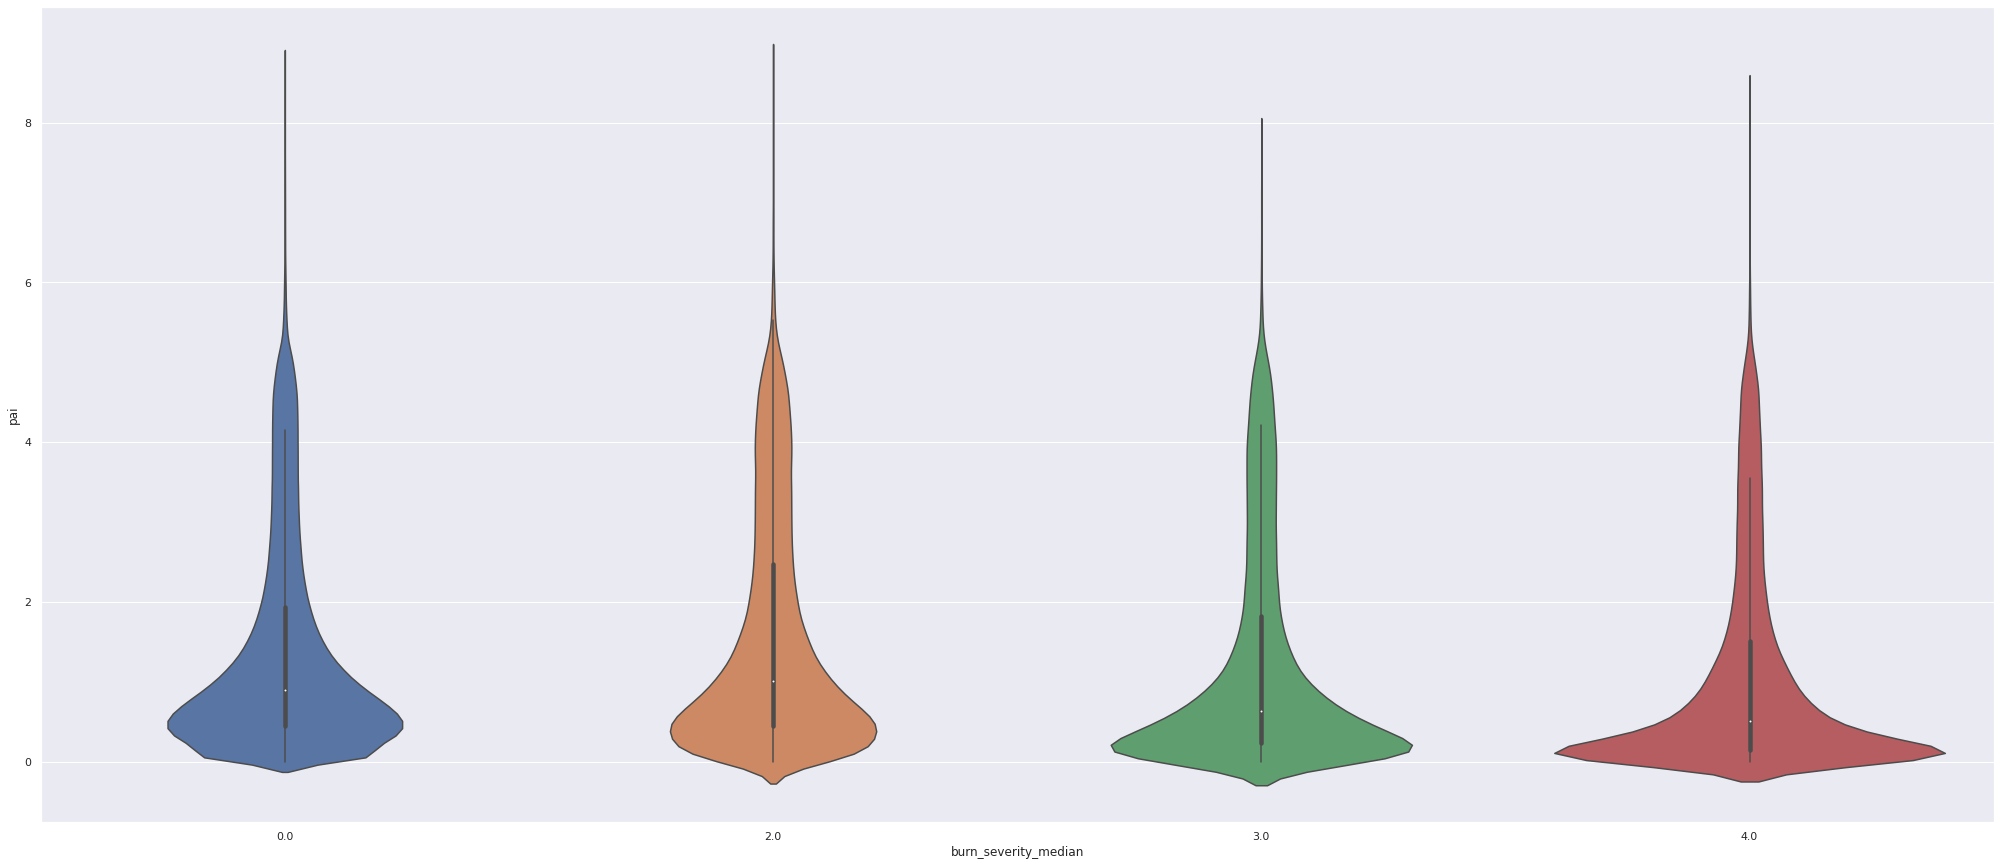

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees, x='burn_severity_median', y='pai')

<AxesSubplot: xlabel='burn_severity_median', ylabel='rh100'>

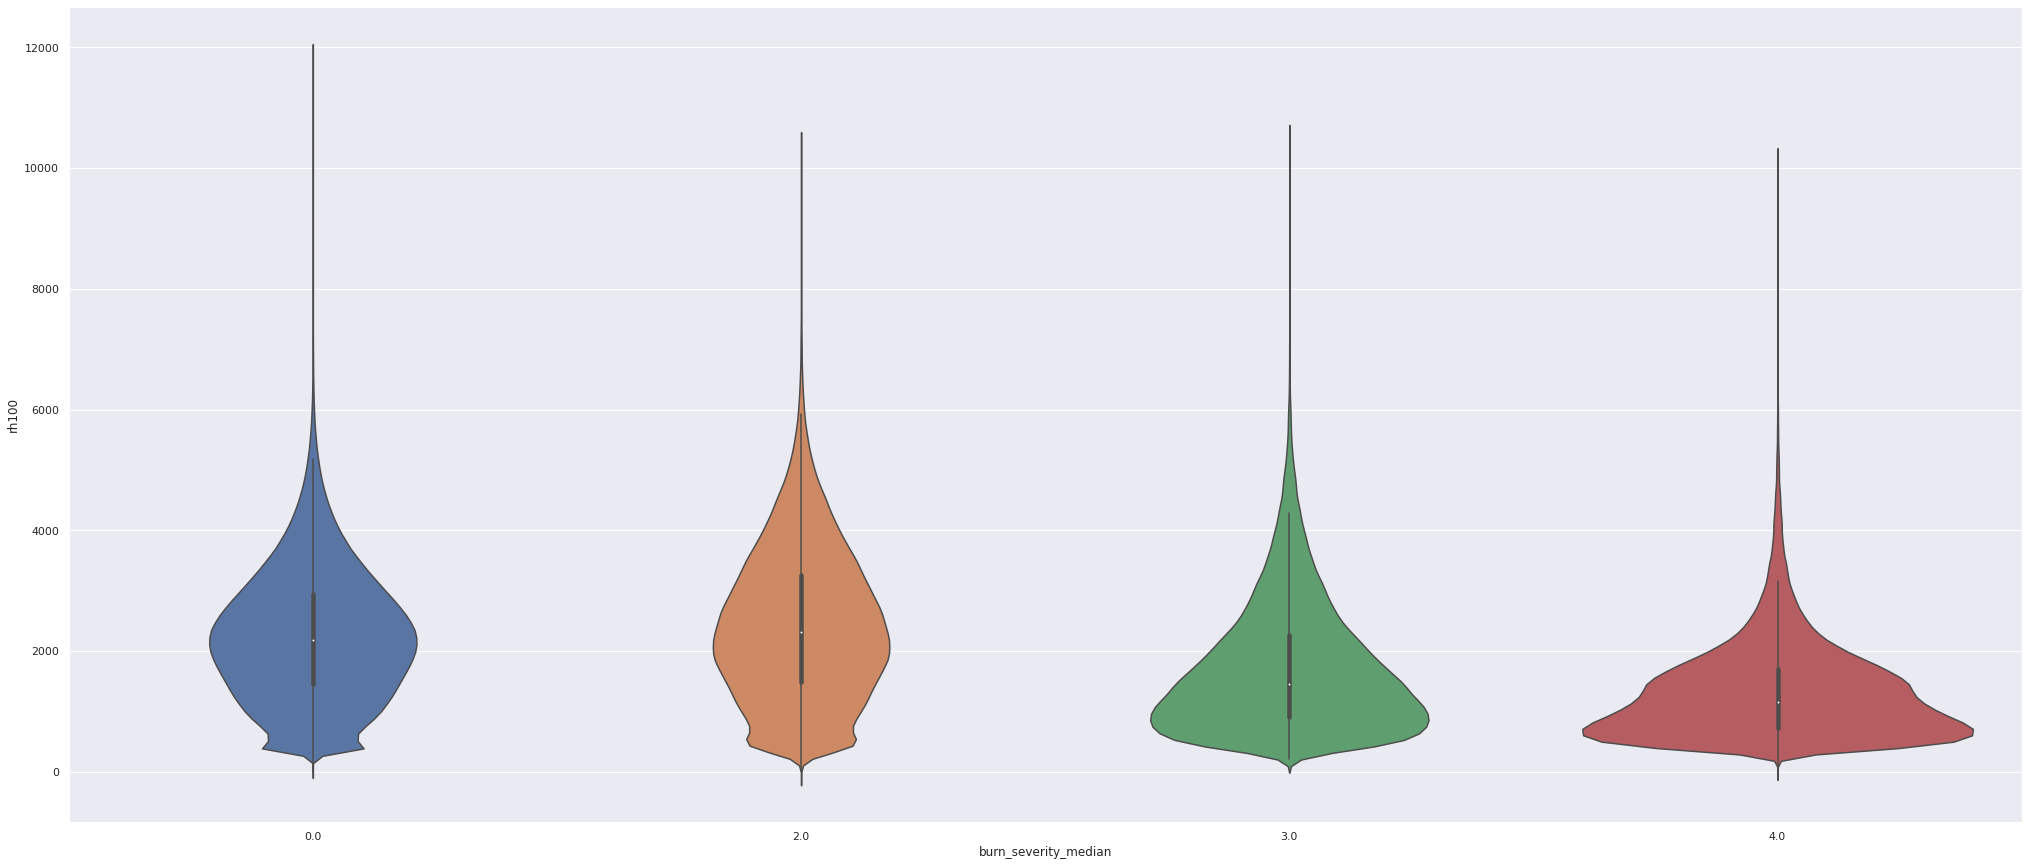

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees, x='burn_severity_median', y='rh100')

<AxesSubplot: xlabel='burn_severity_median', ylabel='pai'>

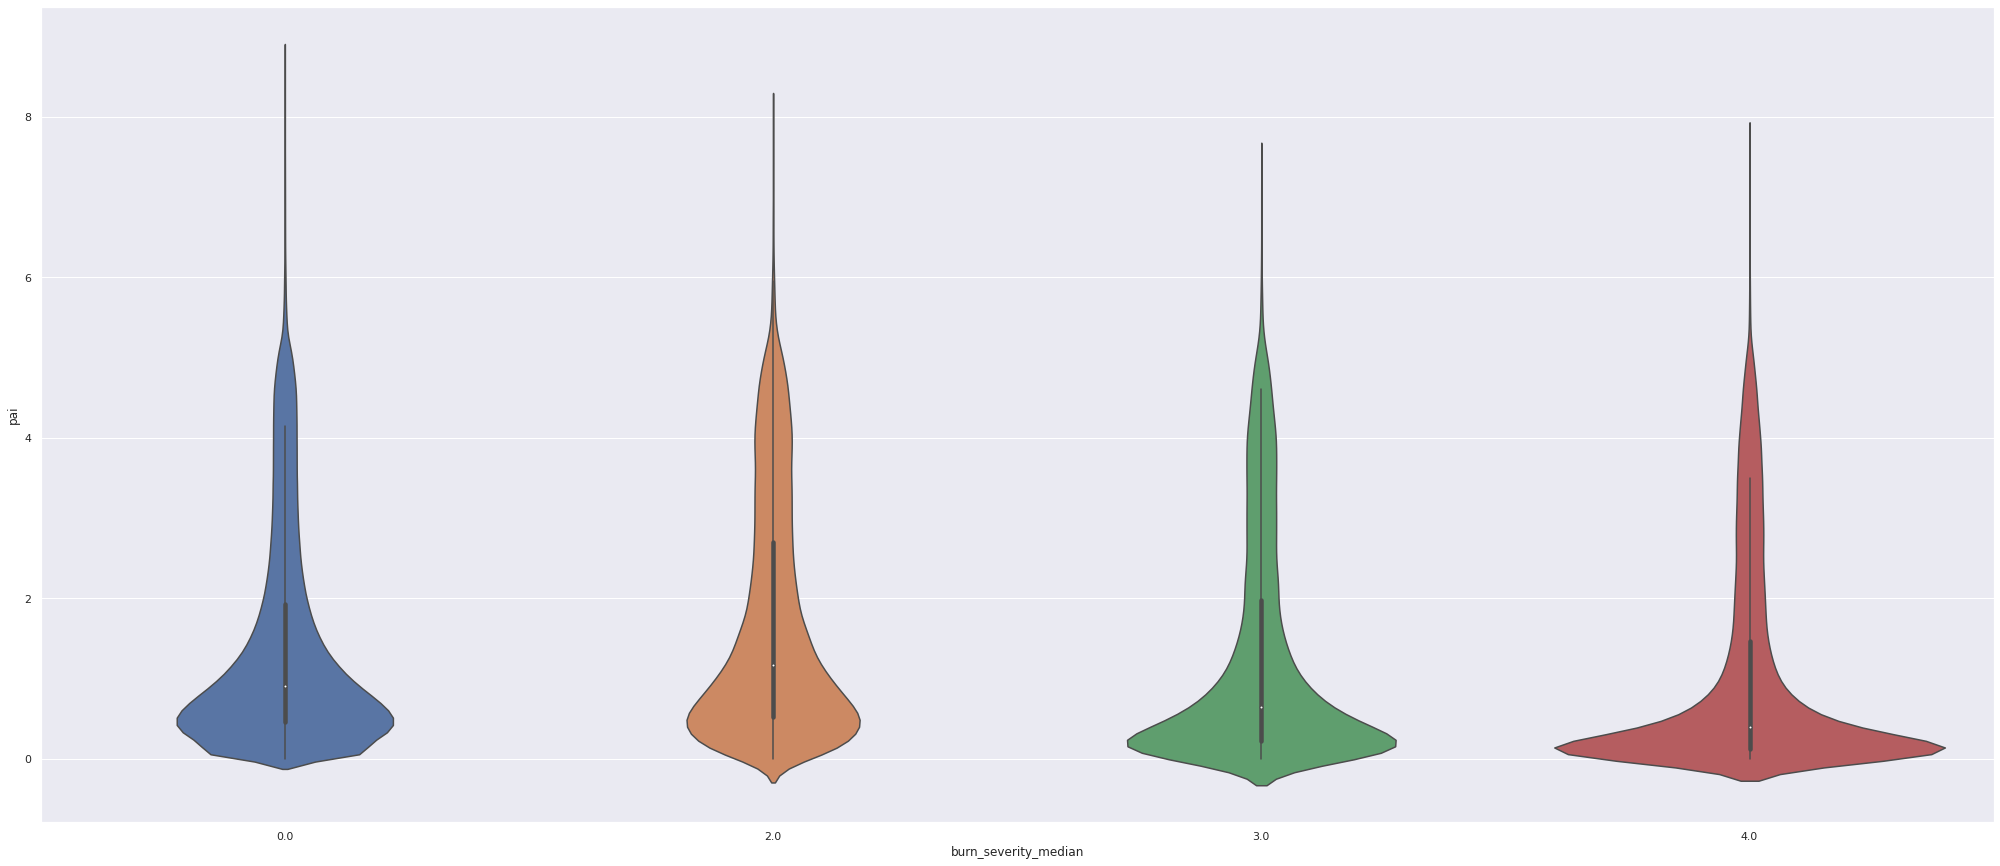

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_10'])], x='burn_severity_median', y='pai')

<AxesSubplot: xlabel='burn_severity_median', ylabel='pai'>

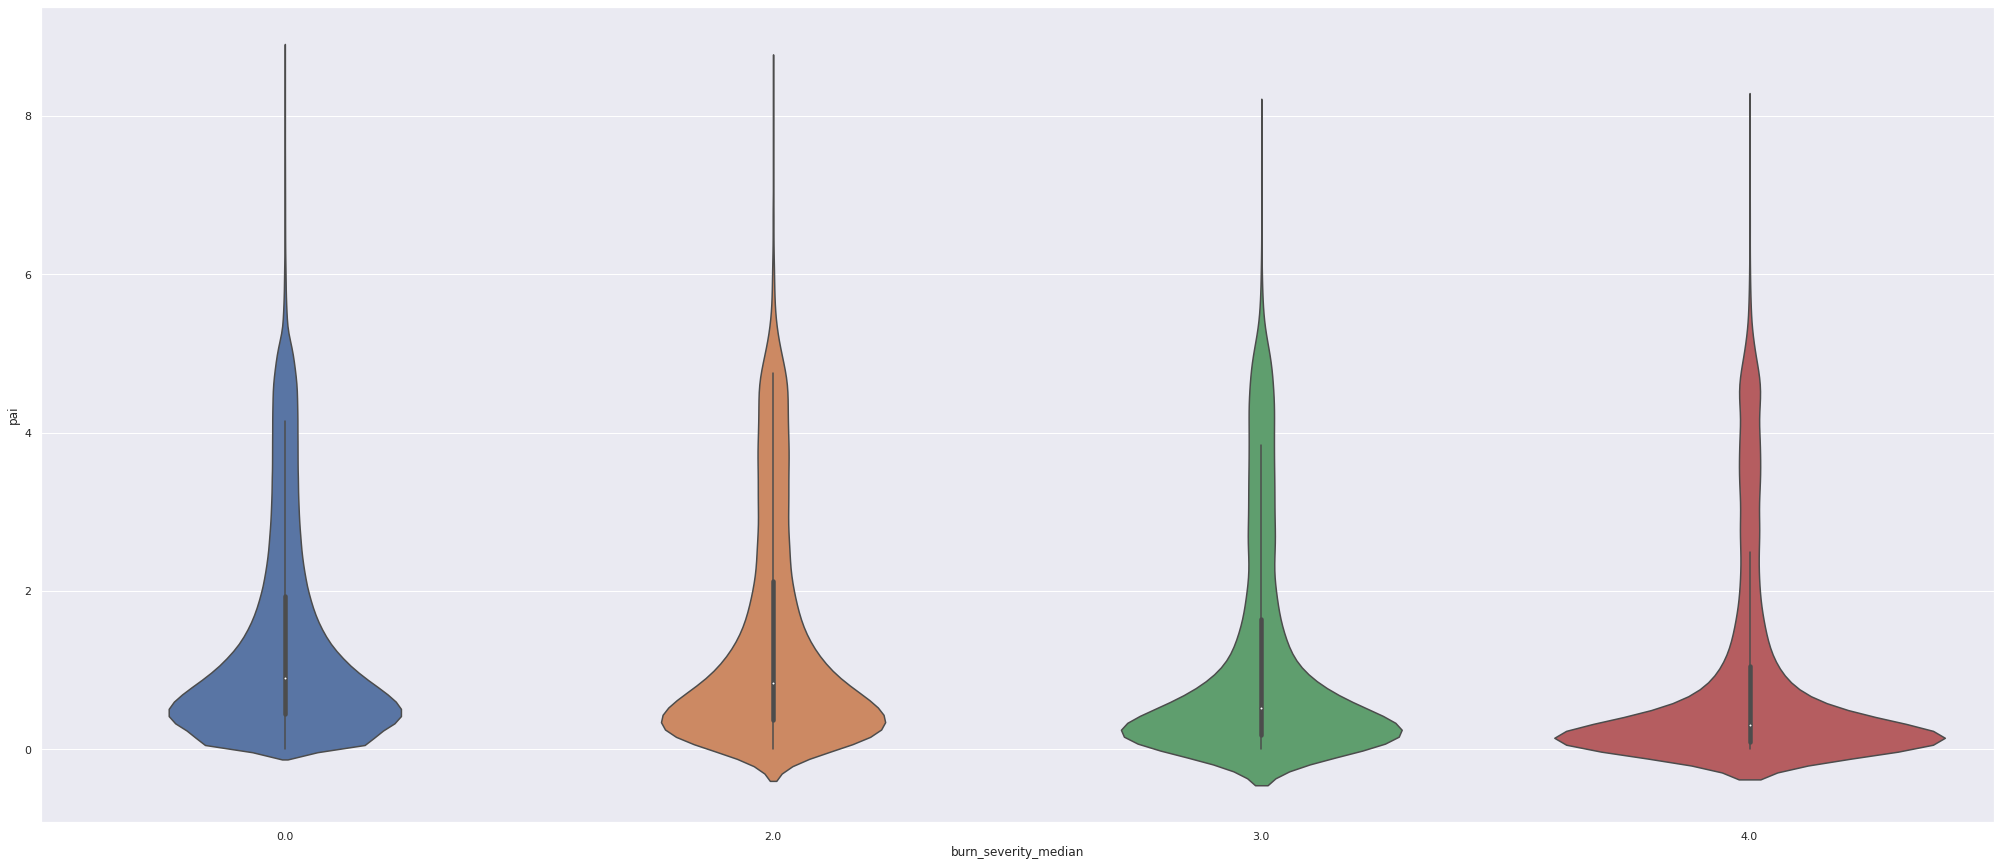

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_20'])], x='burn_severity_median', y='pai')

<AxesSubplot: xlabel='burn_severity_median', ylabel='pai'>

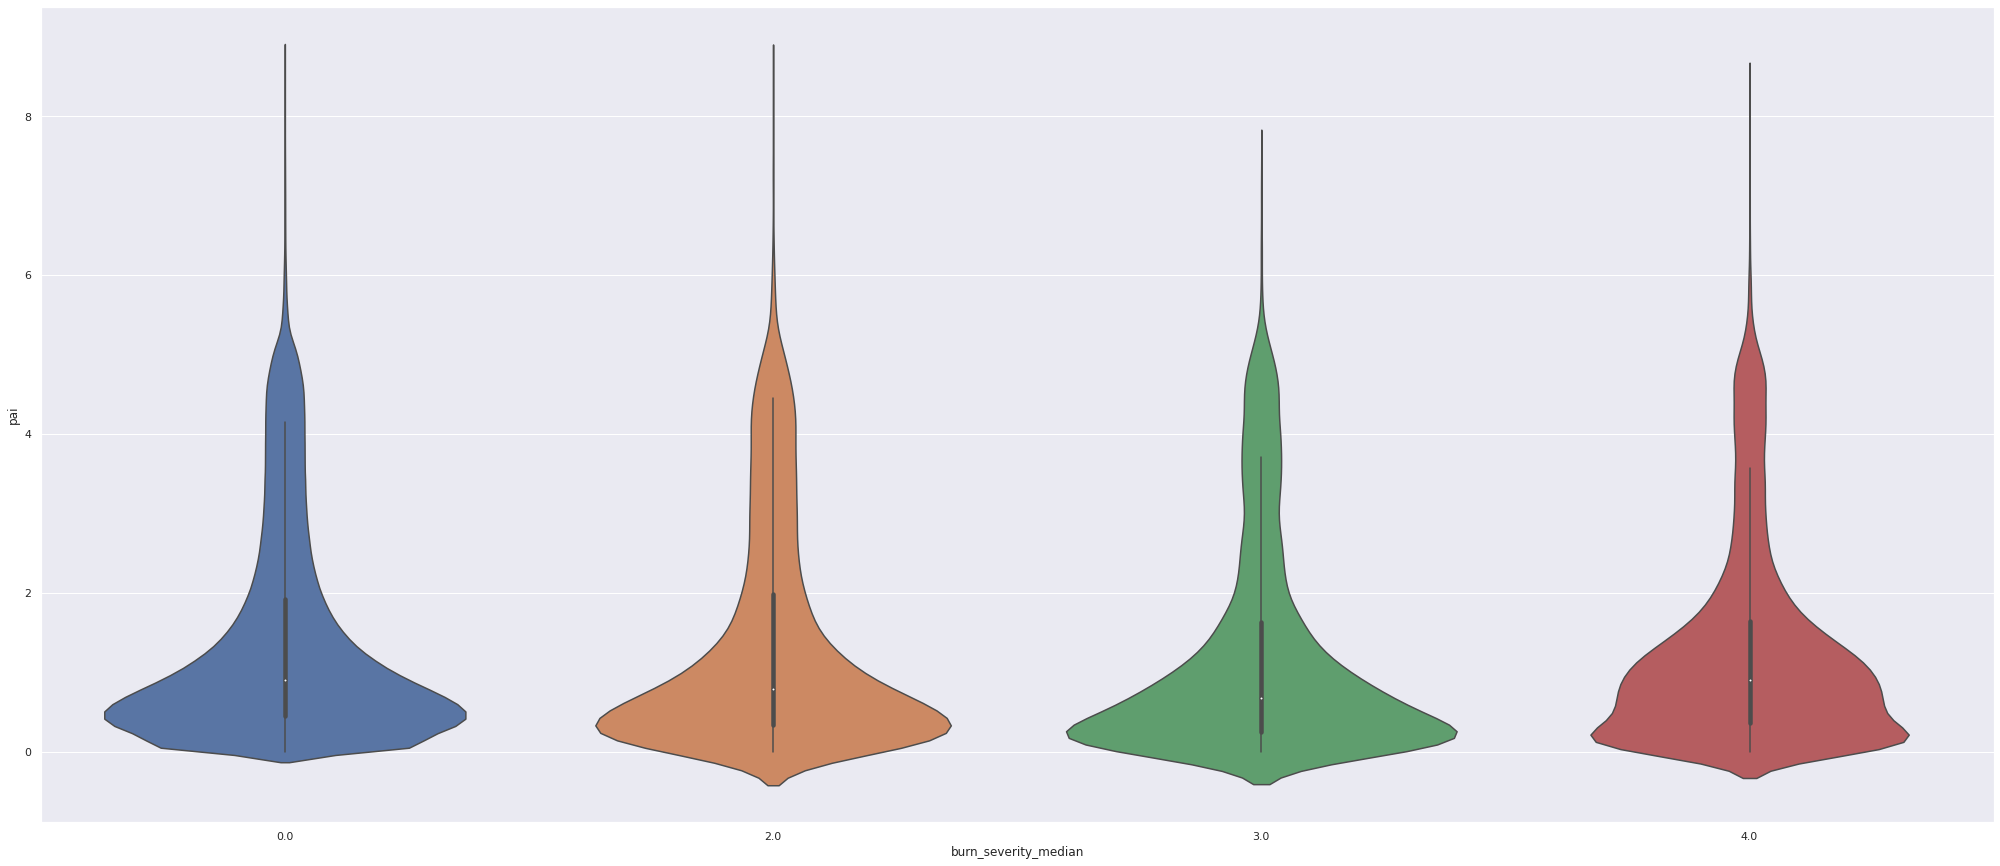

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_30'])], x='burn_severity_median', y='pai')

<AxesSubplot: xlabel='burn_severity_median', ylabel='pai'>

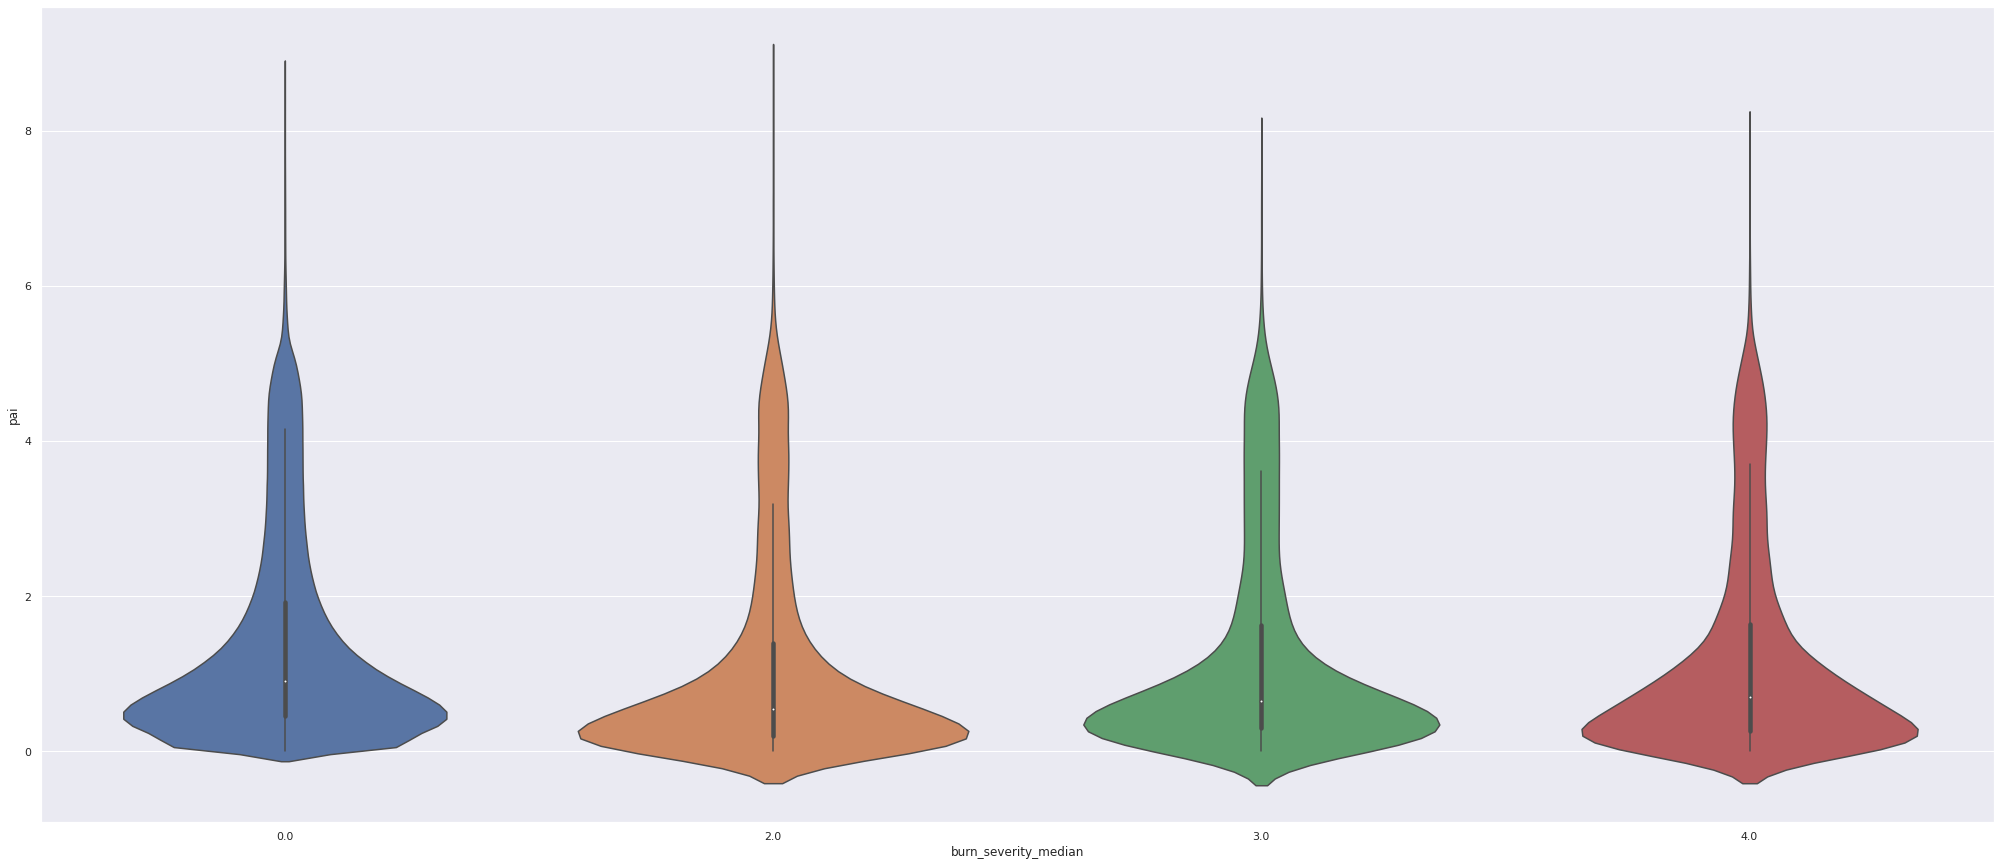

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_40'])], x='burn_severity_median', y='pai')

<AxesSubplot: xlabel='burn_severity_median', ylabel='rh100'>

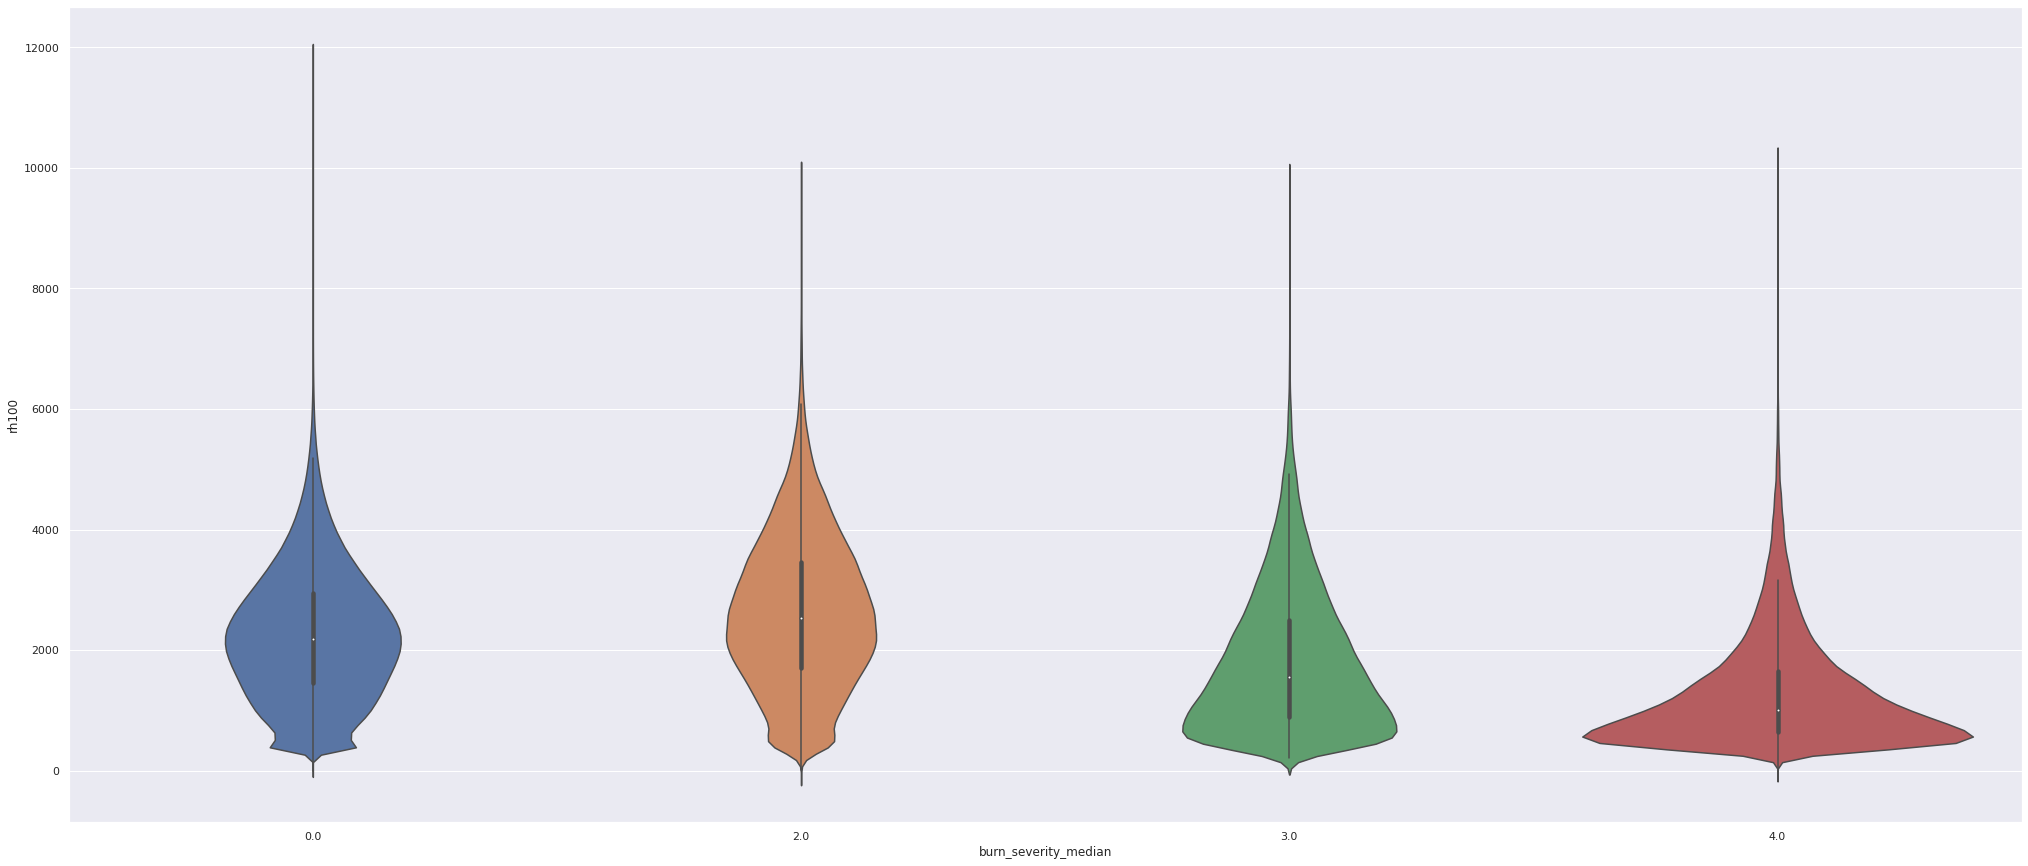

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_10'])], x='burn_severity_median', y='rh100')

<AxesSubplot: xlabel='burn_severity_median', ylabel='rh100'>

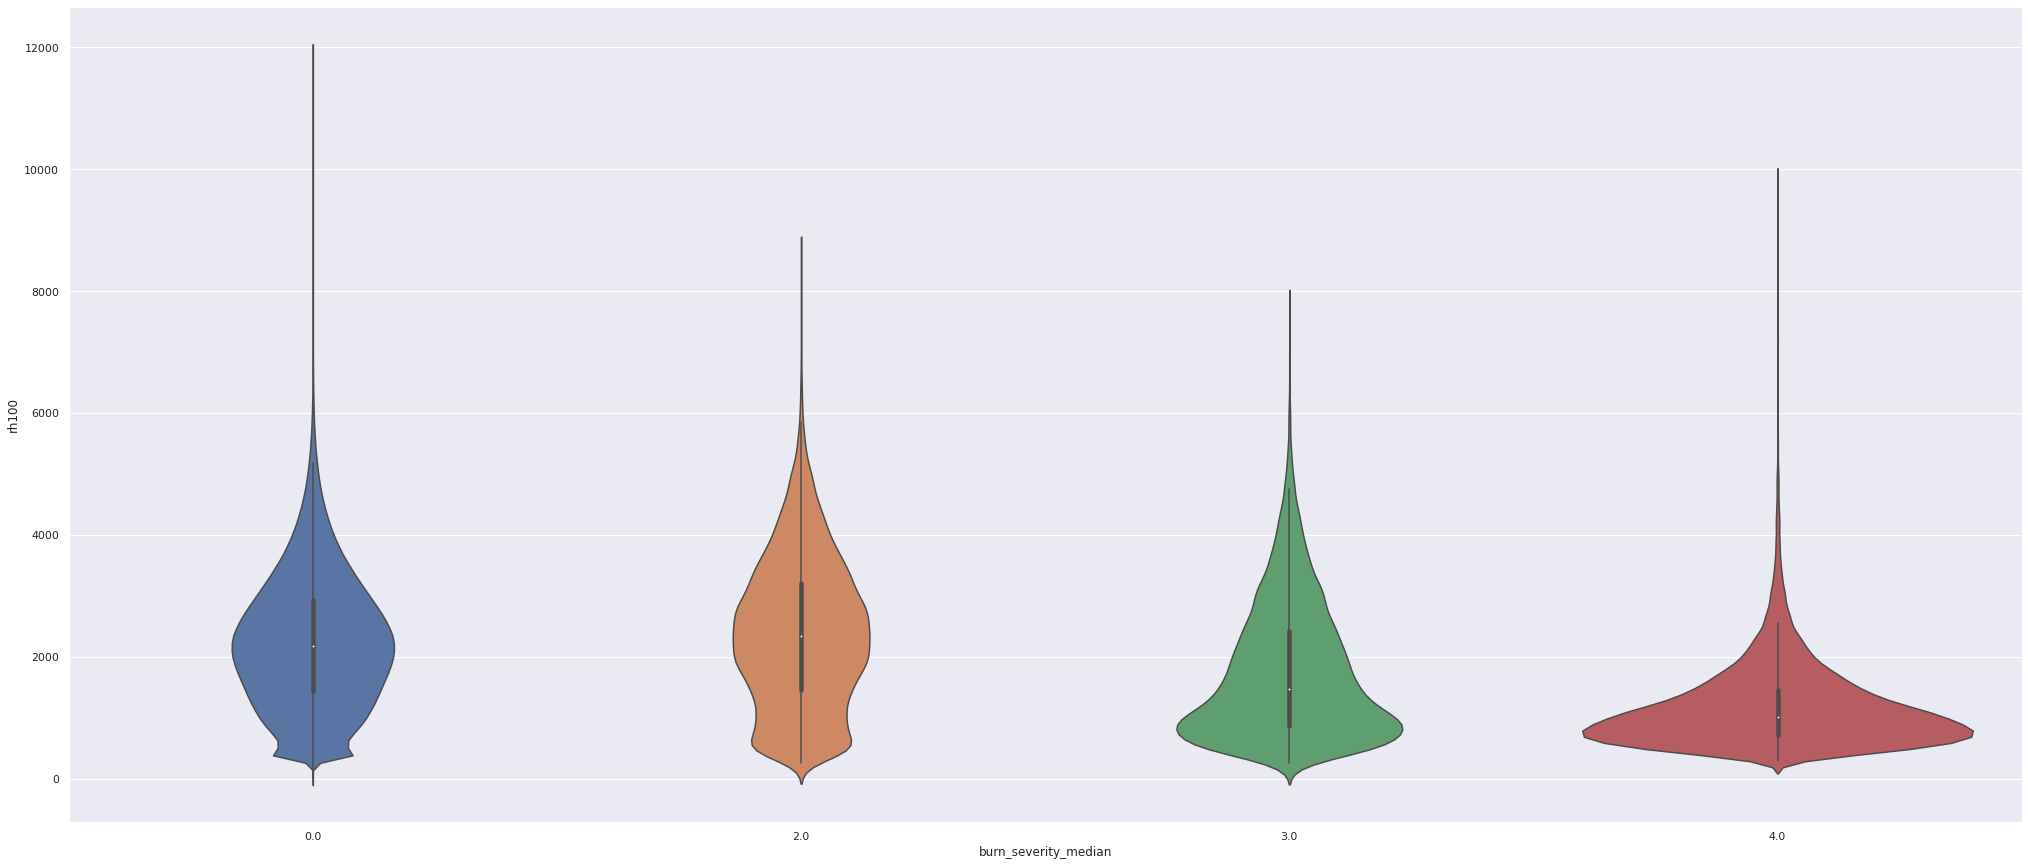

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_20'])], x='burn_severity_median', y='rh100')

<AxesSubplot: xlabel='burn_severity_median', ylabel='rh100'>

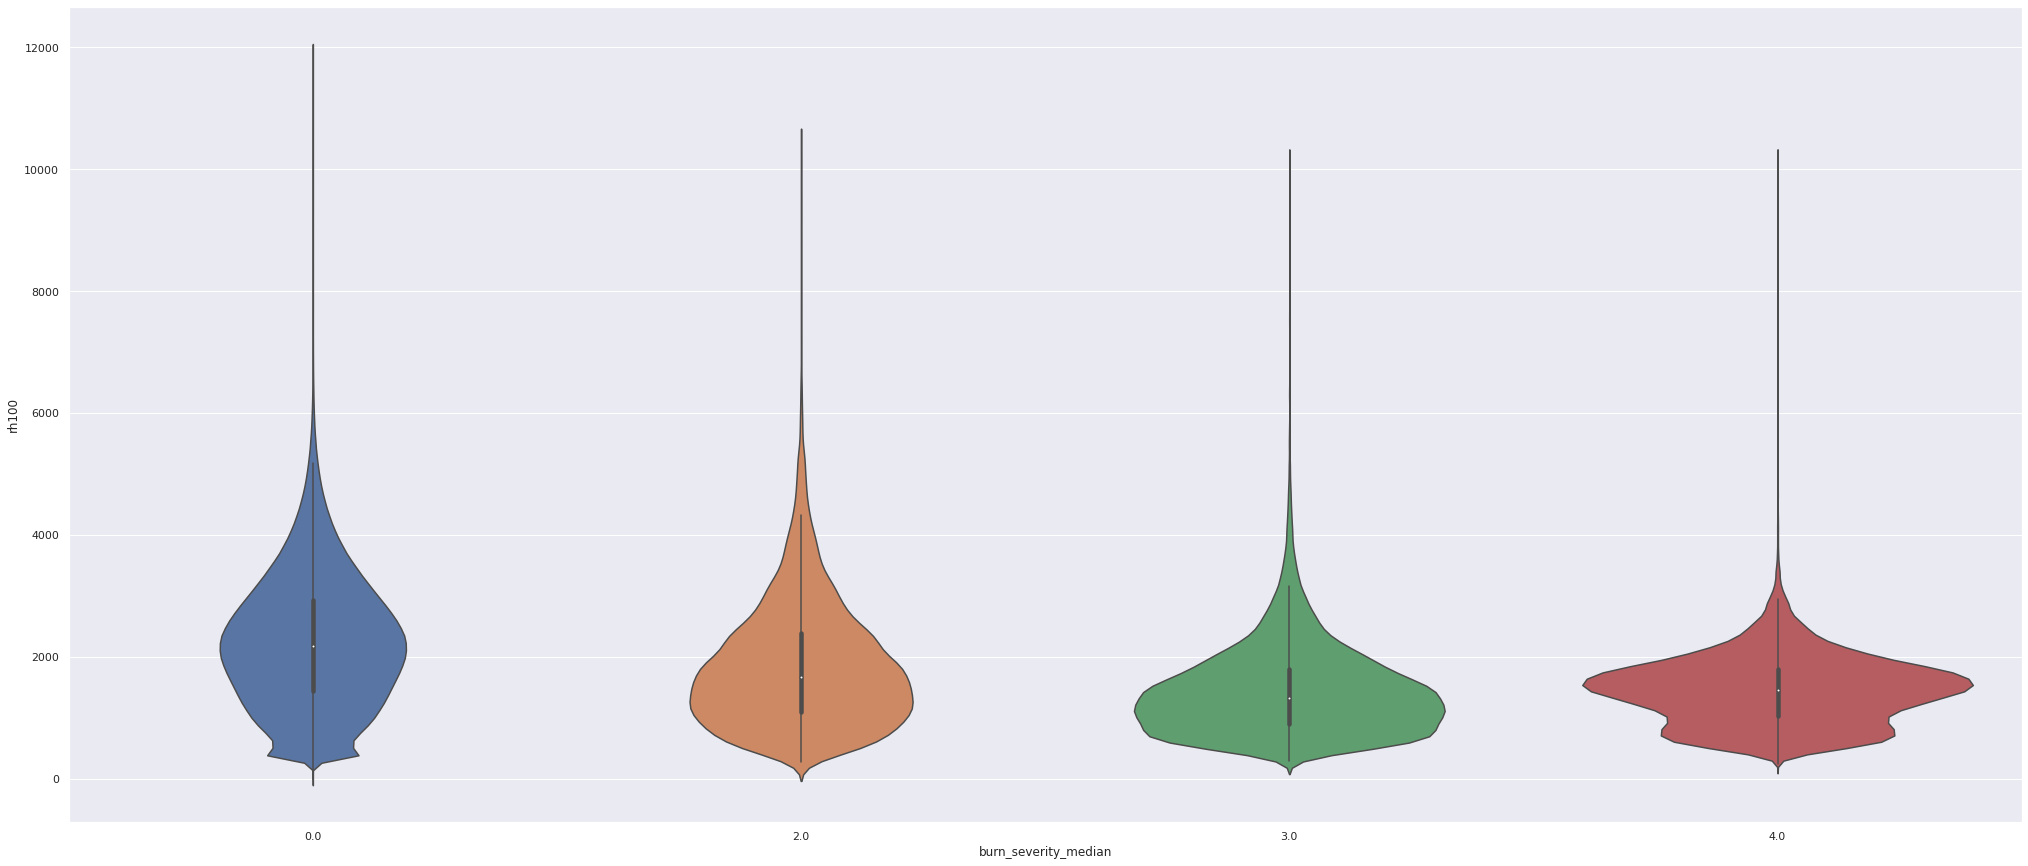

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_30'])], x='burn_severity_median', y='rh100')

<AxesSubplot: xlabel='burn_severity_median', ylabel='rh100'>

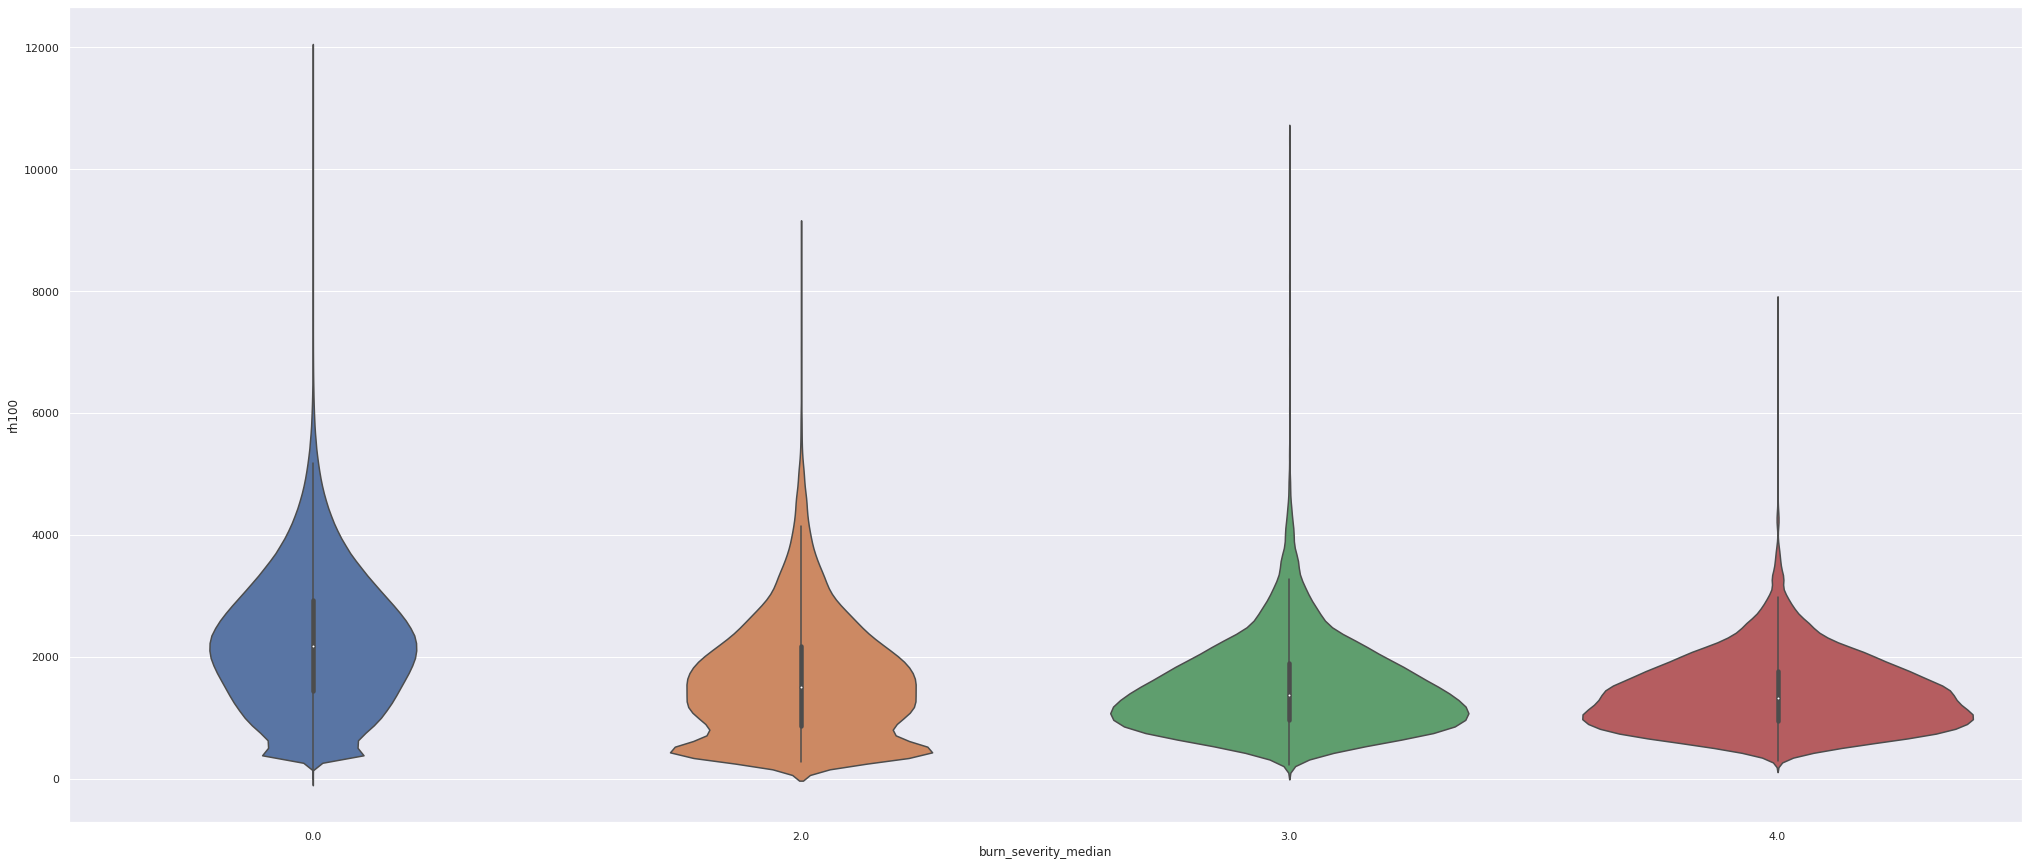

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.violinplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_40'])], x='burn_severity_median', y='rh100')

### Timeplots

<AxesSubplot: xlabel='time_since_burn', ylabel='pai'>

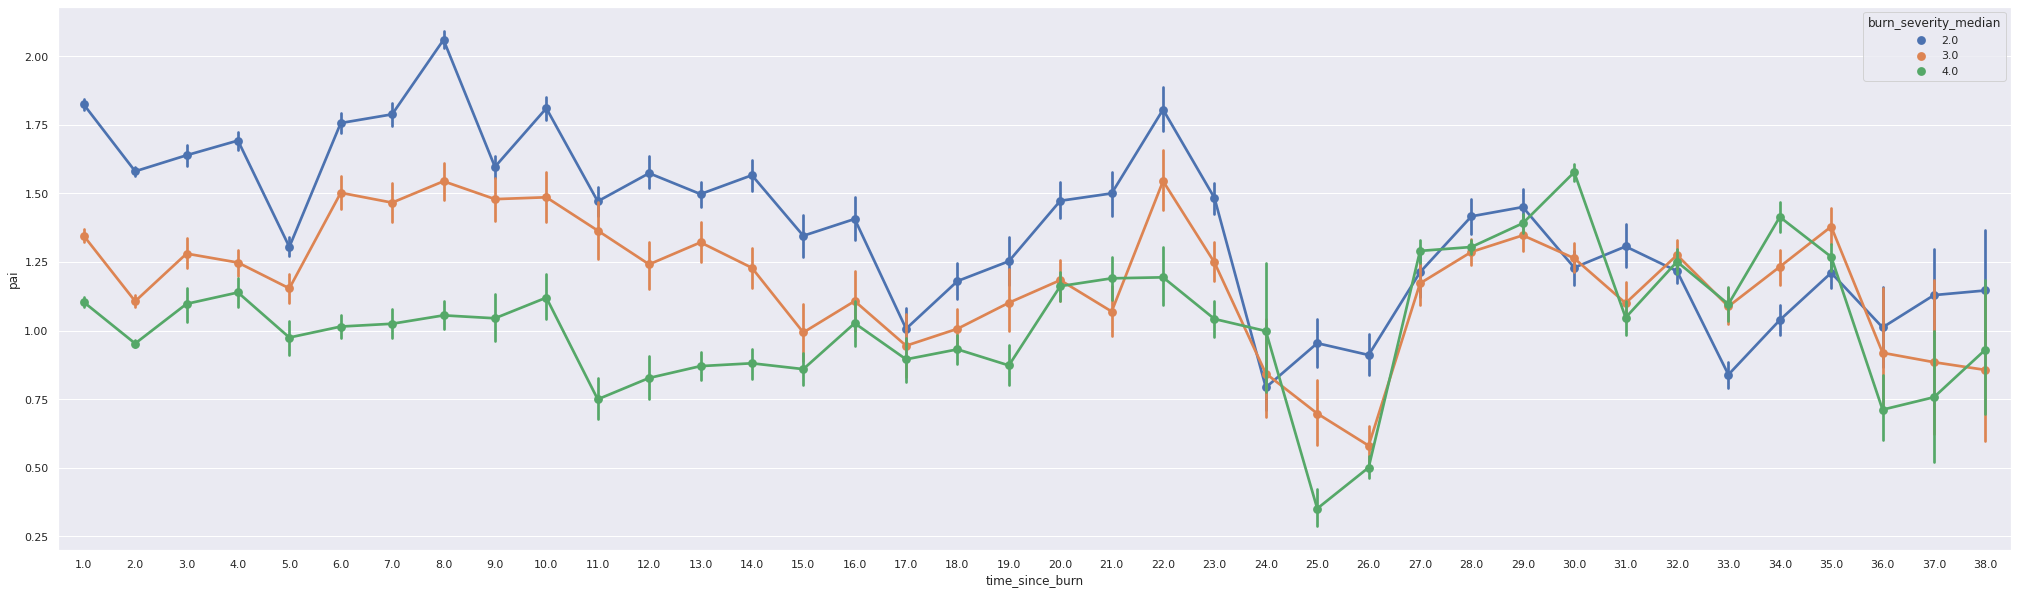

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_trees, x='time_since_burn', y='pai', hue='burn_severity_median')

<AxesSubplot: xlabel='time_since_burn', ylabel='pai'>

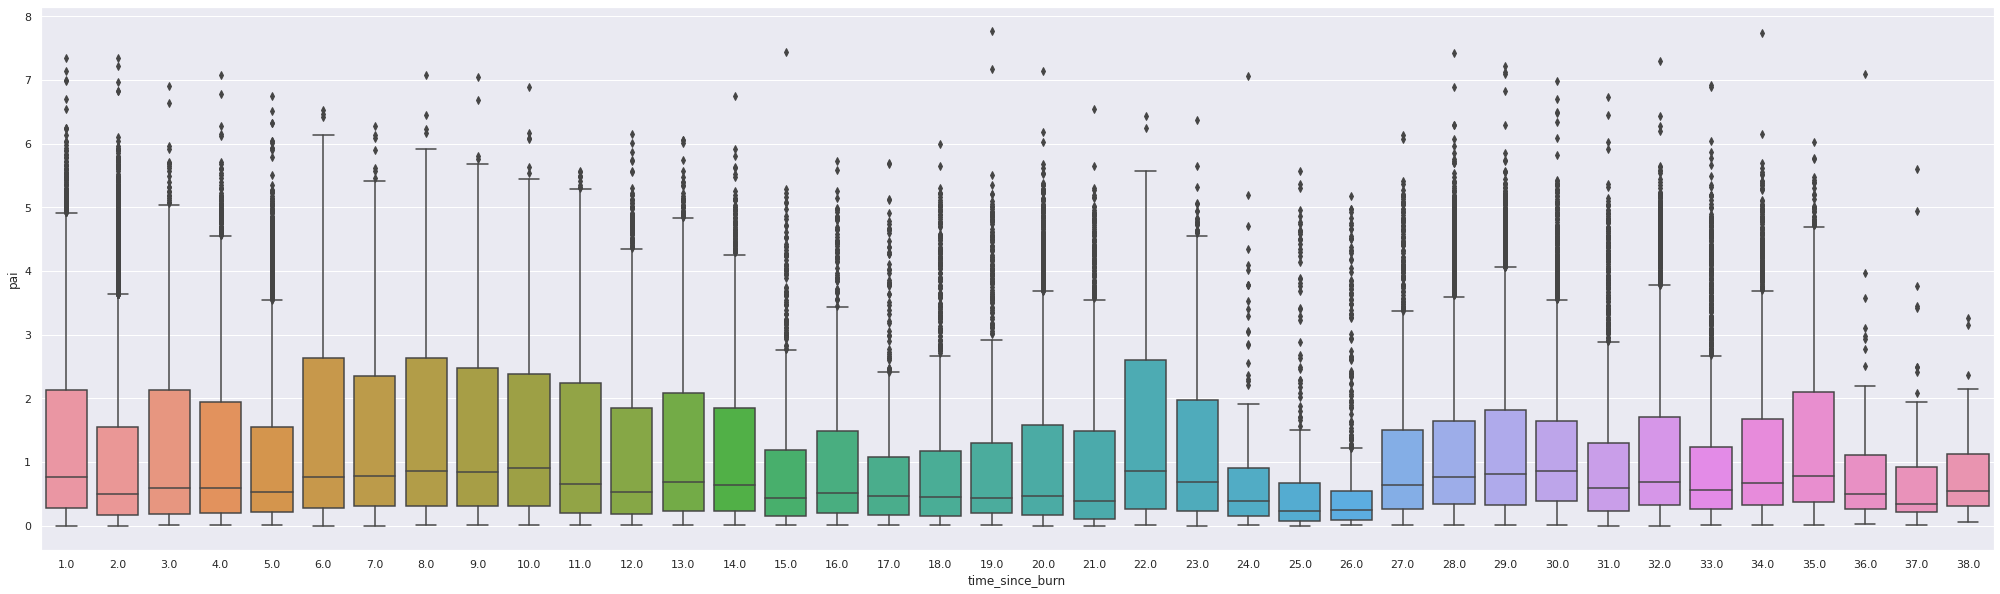

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.boxplot(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3], x='time_since_burn', y='pai')

<AxesSubplot: xlabel='time_since_burn', ylabel='pai'>

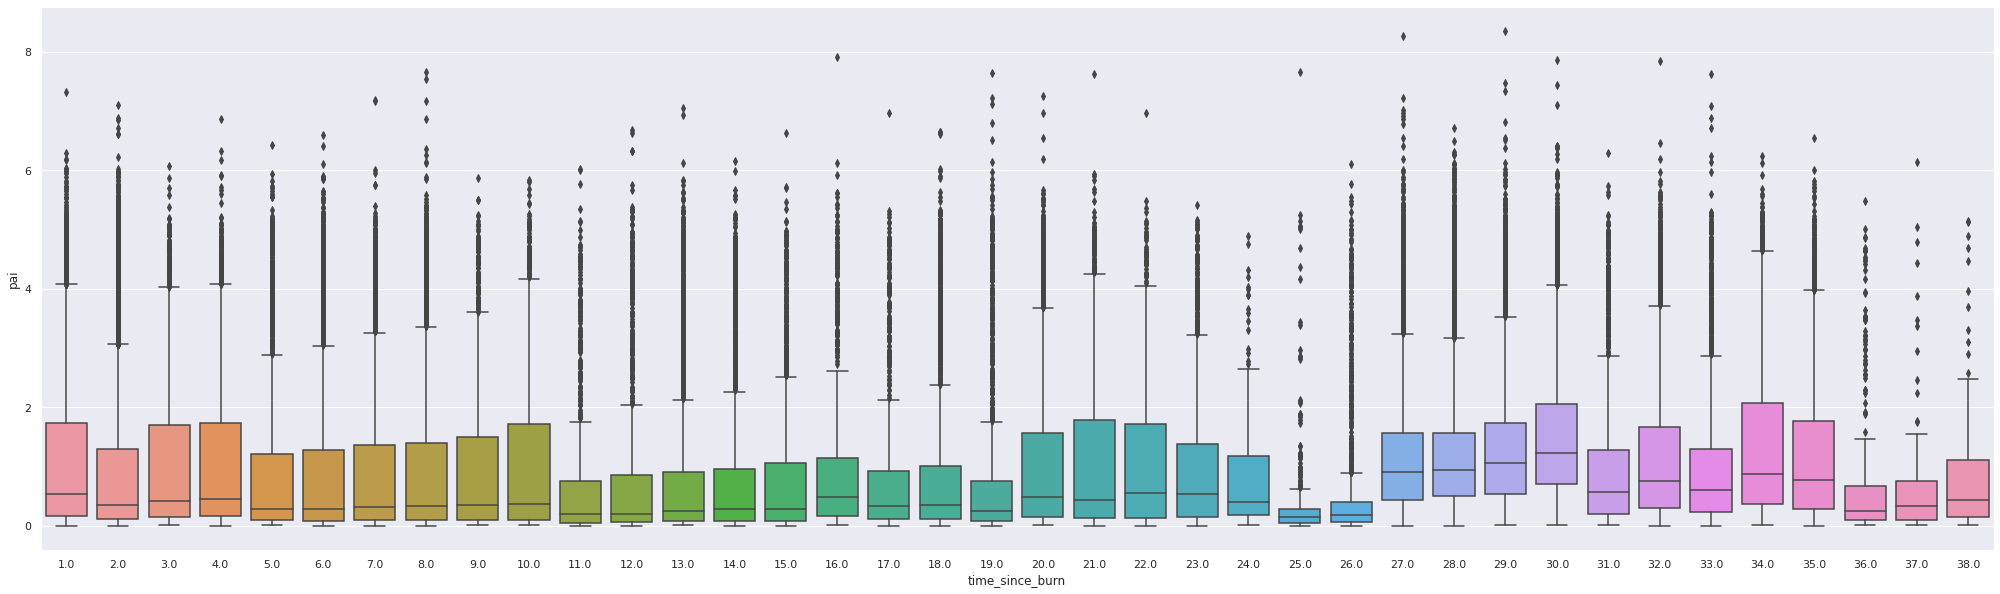

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.boxplot(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4], x='time_since_burn', y='pai')

<AxesSubplot: xlabel='time_since_burn', ylabel='rh100'>

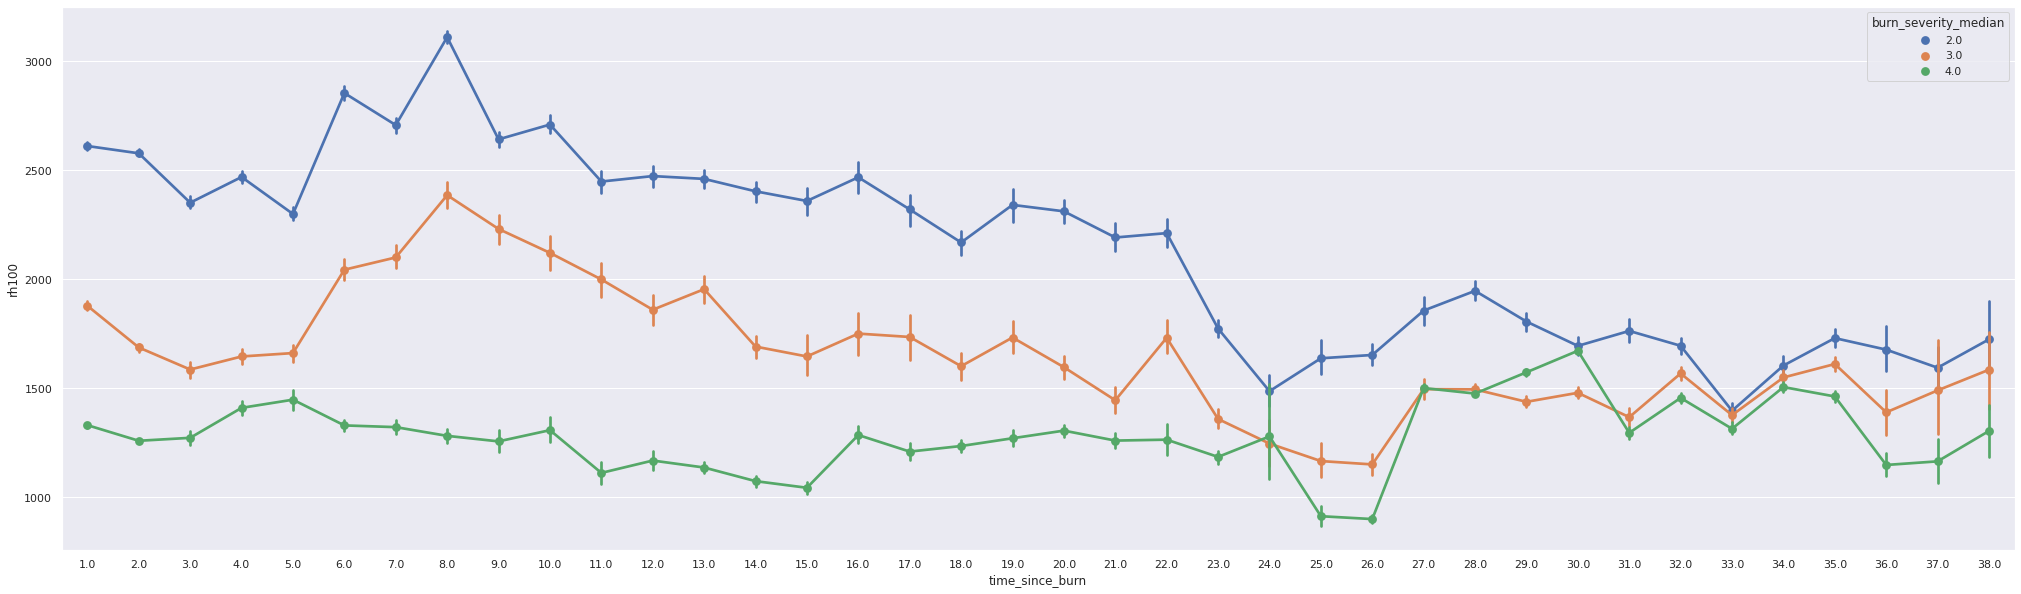

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_trees, x='time_since_burn', y='rh100', hue='burn_severity_median')

Text(0, 0.5, 'GEDI AGBD')

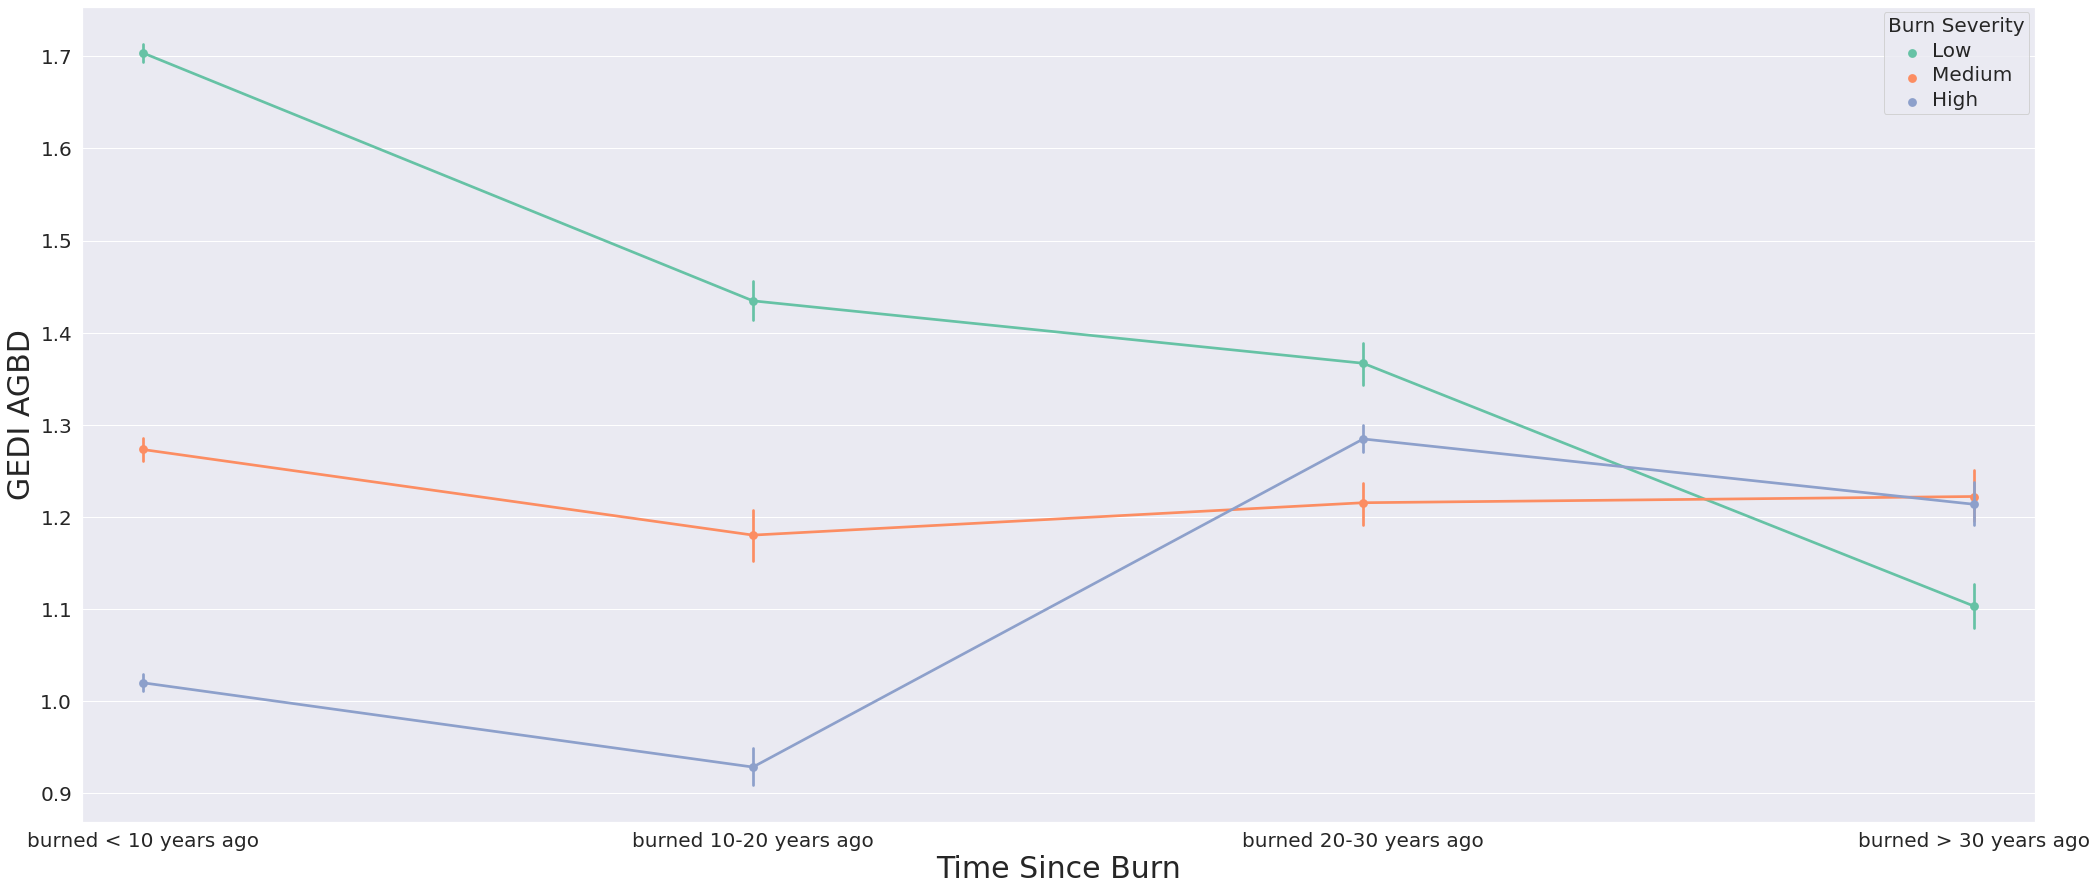

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.pointplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', y='pai', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

140803


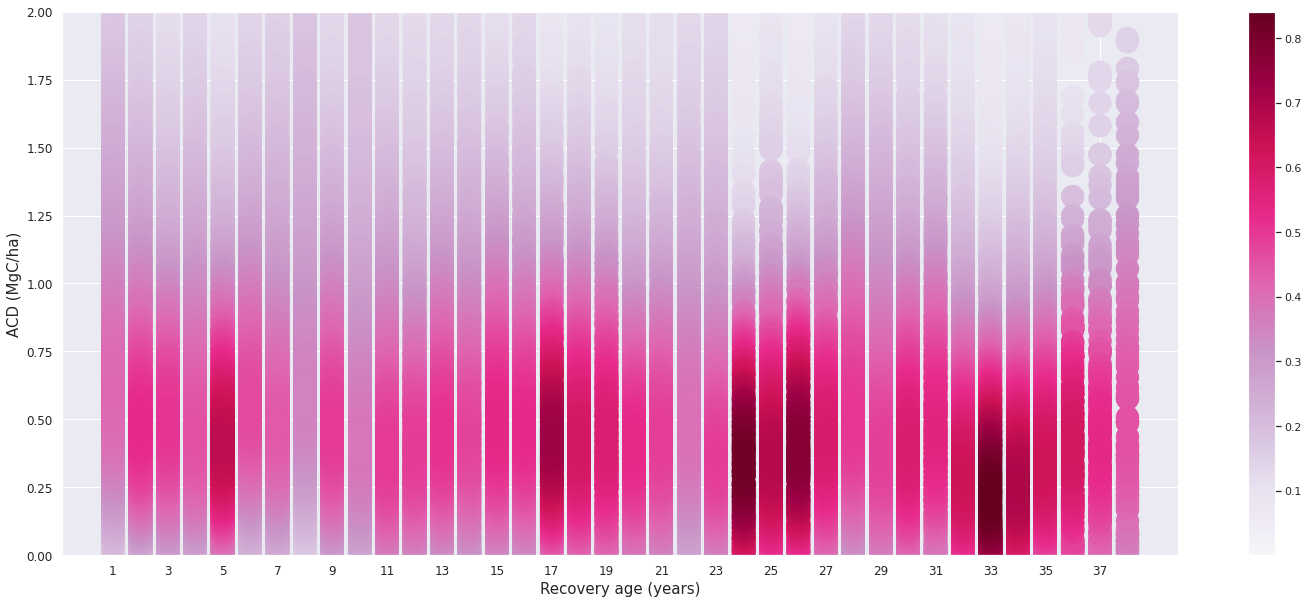

In [55]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2],
         'time_since_burn',
         'pai',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

75757


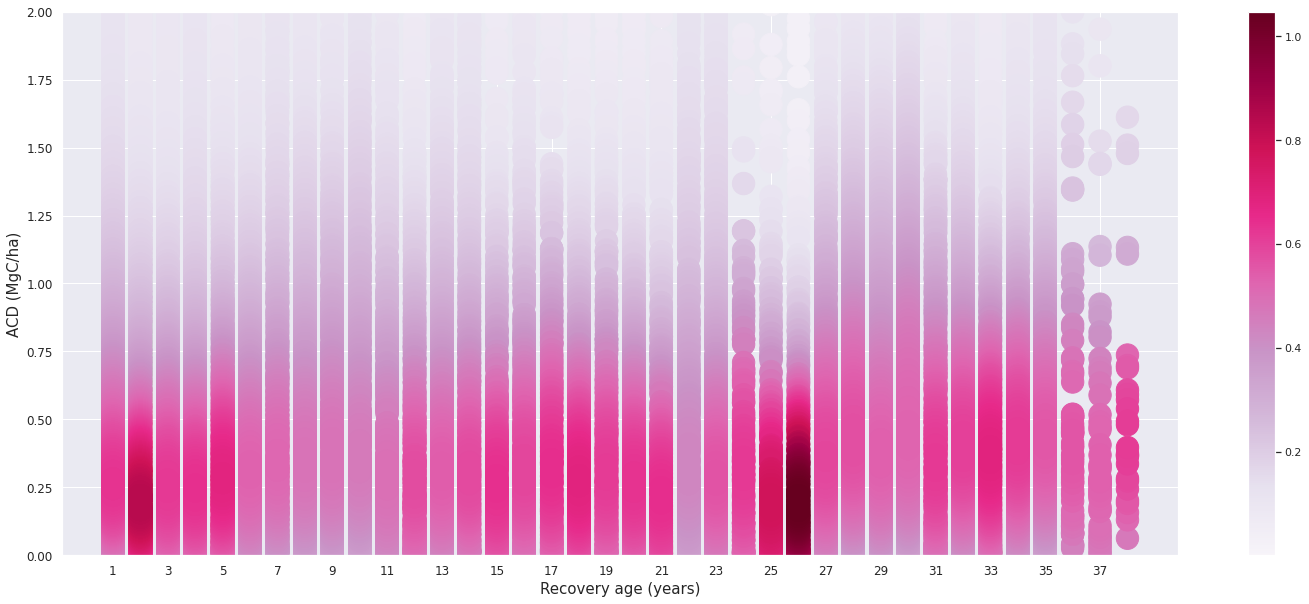

In [56]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3],
         'time_since_burn',
         'pai',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

132663


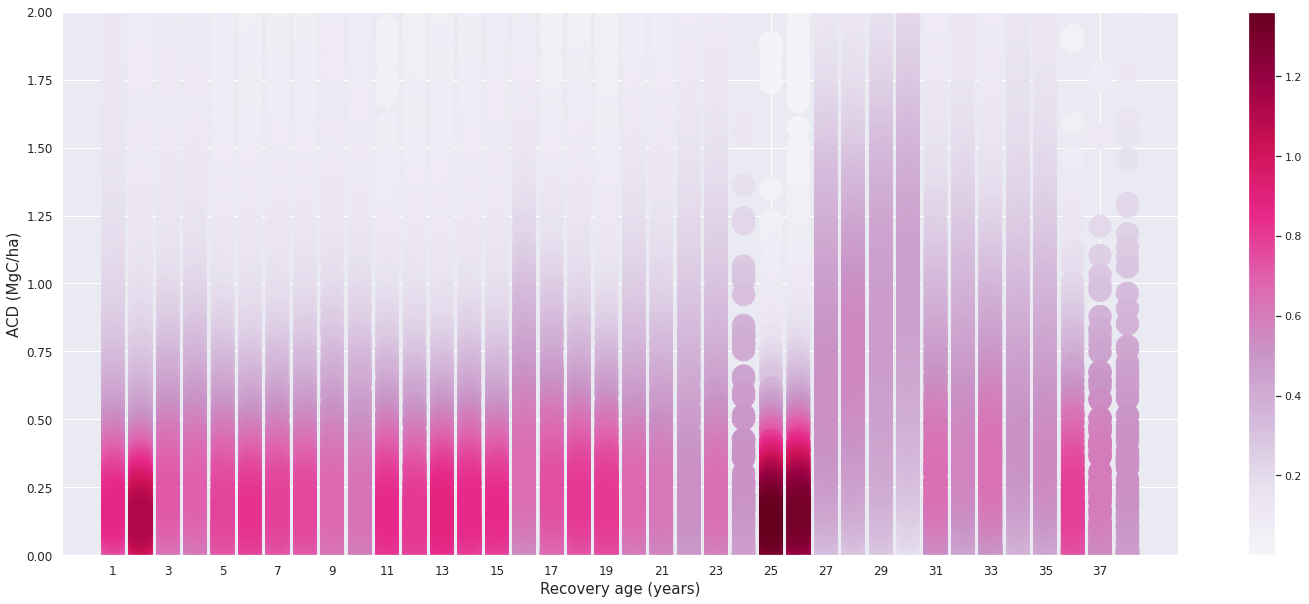

In [59]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4],
         'time_since_burn',
         'pai',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

### Find nearest neighbours

In [60]:
nn_indeces, nn_distances, nn_avg_agbd = k_nn.nearest_neighbors(gedi_burned_trees, gedi_unburned_trees, 'pai', 200)

In [61]:
gedi_burned_trees['rel_pai'] = gedi_burned_trees.pai / nn_avg_agbd
gedi_burned_trees['nn_avg_pai'] = nn_avg_agbd
gedi_burned_trees['nn_index'] = range(0, nn_distances.shape[0])

In [ ]:
gedi_burned_trees.to_csv('/maps/fire-regen/data/burned_trees_rel_pai_200_nn_mean.csv')

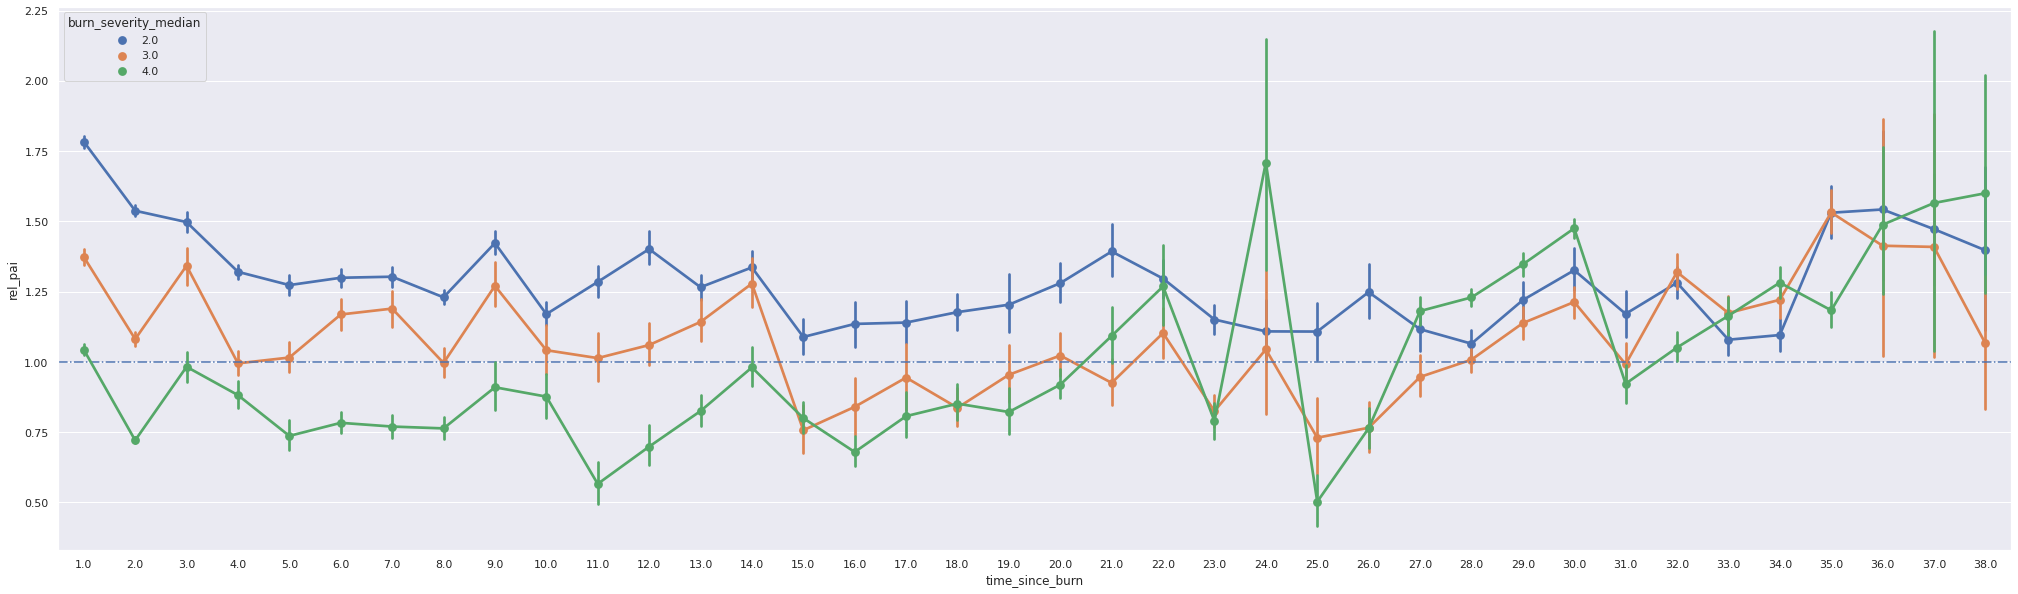

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_trees, x='time_since_burn', y='rel_pai', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

### Vertical PAI

In [64]:
from src.data import pai_vertical

In [65]:
gedi_burned_trees = pai_vertical.transform_pai_z(gedi_burned_trees)

In [72]:
gedi_unburned_trees = pai_vertical.transform_pai_z(gedi_unburned_trees)

In [67]:
delta_low = np.mean(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2].pai_z_delta_np.to_numpy(), axis=0)
delta_medium = np.mean(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3].pai_z_delta_np.to_numpy(), axis=0)
delta_high = np.mean(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4].pai_z_delta_np.to_numpy(), axis=0)

In [73]:
delta_unburned= np.mean(gedi_unburned_trees.pai_z_delta_np.to_numpy(), axis=0)

In [74]:
p2_drought_delta = pd.DataFrame({'low': delta_low, 'medium': delta_medium, 'high': delta_high, 'unburned': delta_unburned})
p2_drought_delta.index.name = 'index'

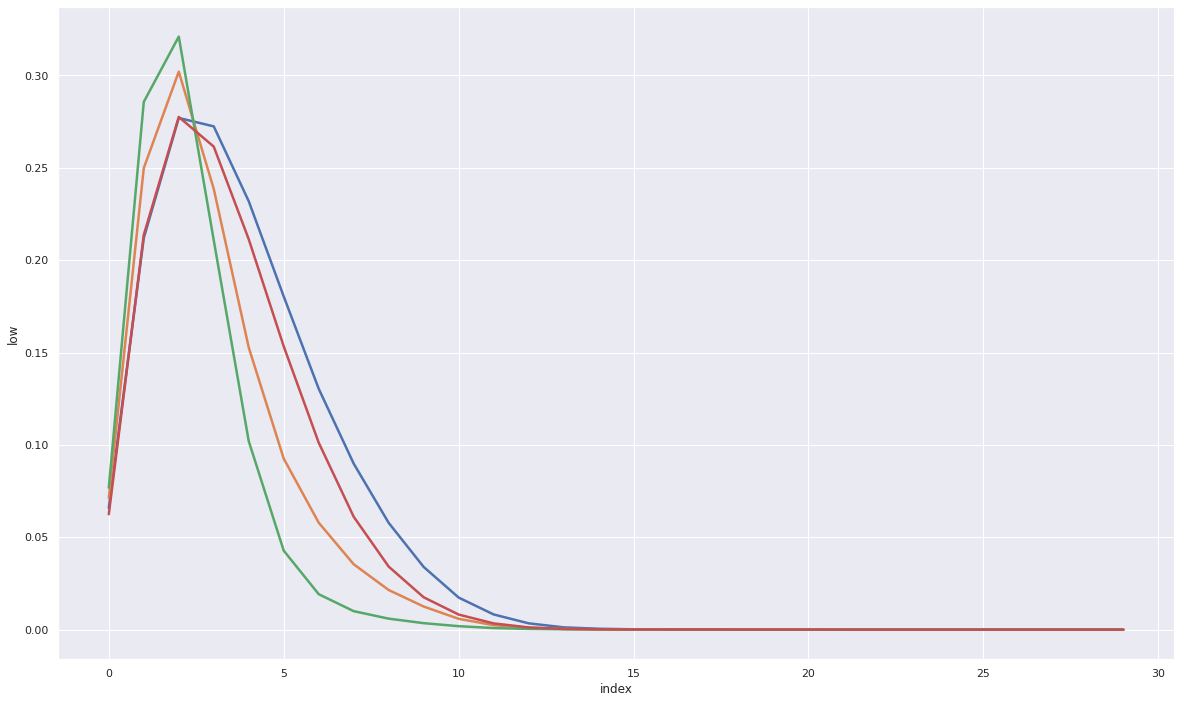

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
g = sns.lineplot(p2_drought_delta, x='index', y='low', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='medium', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='high', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='unburned', ax=ax, linewidth=2.5)
#g = sns.lineplot(p2_drought_delta, x='index', y='during', ax=ax, label='During 2020 drought', color='red', linewidth=2.5)


### High Severity Vertical Recovery

In [122]:
gedi_sev = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]

In [123]:
delta_burn_10 = np.mean(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_10'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_20 = np.mean(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_20'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_30 = np.mean(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_30'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_40 = np.mean(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_40'].pai_z_delta_np.to_numpy(), axis=0)


In [124]:
delta_burn_10_s = np.std(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_10'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_20_s = np.std(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_20'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_30_s = np.std(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_30'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_40_s = np.std(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_40'].pai_z_delta_np.to_numpy(), axis=0)


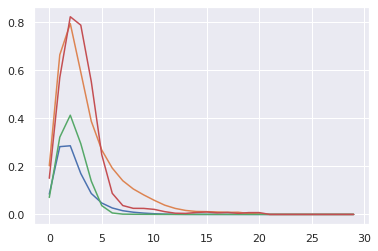

In [125]:
plt.plot(delta_burn_10)
plt.plot(delta_burn_10 + delta_burn_10_s)
plt.plot(delta_burn_30)
plt.plot(delta_burn_30 + delta_burn_30_s)


In [126]:
p2_drought_delta = pd.DataFrame({'low': delta_burn_10, 'medium': delta_burn_20, 'high': delta_burn_30, 'unburned': delta_burn_40})
p2_drought_delta.index.name = 'index'

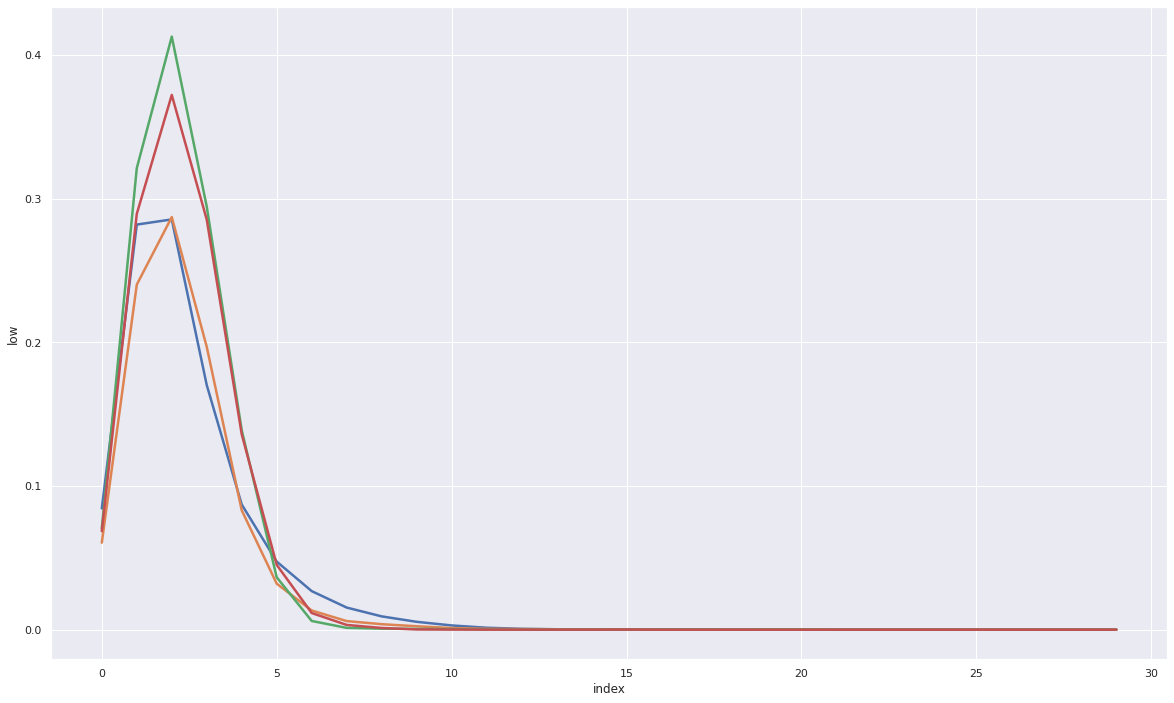

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
g = sns.lineplot(p2_drought_delta, x='index', y='low', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='medium', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='high', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='unburned', ax=ax, linewidth=2.5)
#g = sns.lineplot(p2_drought_delta, x='index', y='during', ax=ax, label='During 2020 drought', color='red', linewidth=2.5)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
g = sns.lineplot(p2_drought_delta, x='index', y='low', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='medium', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='high', ax=ax, linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='unburned', ax=ax, linewidth=2.5)
#g = sns.lineplot(p2_drought_delta, x='index', y='during', ax=ax, label='During 2020 drought', color='red', linewidth=2.5)


### Medium Severity Recovery

In [ ]:
delta_burn_10 = np.mean(gedi_burned_trees[gedi_burned_trees.time_since_burn_cat == 'burn_10'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_20 = np.mean(gedi_burned_trees[gedi_burned_trees.time_since_burn_cat == 'burn_20'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_30 = np.mean(gedi_burned_trees[gedi_burned_trees.time_since_burn_cat == 'burn_30'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_40 = np.mean(gedi_burned_trees[gedi_burned_trees.time_since_burn_cat == 'burn_40'].pai_z_delta_np.to_numpy(), axis=0)

### Vertical PAI using median

gedi_sev = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]

In [87]:
gedi_sev = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]

In [93]:
delta_burn_10 = np.std(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_10'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_20 = np.std(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_20'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_30 = np.std(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_30'].pai_z_delta_np.to_numpy(), axis=0)
delta_burn_40 = np.mean(gedi_sev[gedi_sev.time_since_burn_cat == 'burn_40'].pai_z_delta_np.to_numpy(), axis=0)
